In [61]:
import pandas as pd 
import requests
import os
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from matplotlib import dates as mdates
import pylab
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import boxcox
from scipy.special import inv_boxcox
pylab.rcParams['figure.figsize'] = (14,10)
%matplotlib inline




In [2]:
url = "https://min-api.cryptocompare.com/data/v2/histoday"


In [3]:
key = os.getenv("cryptocompare_key")

In [4]:
payload = {
    "api_key": key,
    "fsym": "BTC",
    "tsym": "USD",
    "limit": 730
}

In [5]:
result = requests.get(url, params = payload).json()

In [6]:
coin_df = pd.DataFrame(result['Data']['Data'])

In [7]:
coin_df['time'] = pd.to_datetime(coin_df['time'], unit = 's')

In [8]:
coin_df = coin_df.drop(columns = ['volumefrom', 'volumeto', 'conversionType', 'conversionSymbol'])

In [9]:
coin_df = coin_df.rename(columns = {'time': 'Date'})

In [10]:
coin_df = coin_df.set_index('Date')

In [11]:
coin_df.head()


,high,low,open,close
Date,,,,
2018-01-07,17184.81,15791.13,17174.50,16228.16
2018-01-08,16302.92,13902.31,16228.26,14976.17
2018-01-09,15390.28,14221.55,14976.17,14468.50
2018-01-10,14919.49,13450.54,14468.09,14919.49
2018-01-11,14979.96,12825.95,14920.36,13308.06


In [12]:
close_df = pd.DataFrame(coin_df['close'])

In [13]:
close_df.head()

,close
Date,
2018-01-07,16228.16
2018-01-08,14976.17
2018-01-09,14468.50
2018-01-10,14919.49
2018-01-11,13308.06


In [14]:
stationary_test = adfuller(close_df['close'])
print(stationary_test[1])

0.019036763605199344


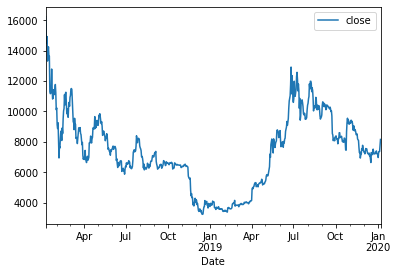

In [15]:
close_df.plot()
plt.show()

In [16]:
transform_data, lmda = boxcox(close_df)

In [17]:
print(lmda)

[0.64453558]


In [18]:
transformed_df = close_df.copy()

In [19]:
transformed_data = transform_data.flatten().tolist()

In [20]:
transformed_df['close'] = transformed_data

In [21]:
transformed_df.head()

,close
Date,
2018-01-07,800.904891
2018-01-08,760.435284
2018-01-09,743.684913
2018-01-10,758.575271
2018-01-11,704.590072


In [22]:
transformed_df.tail()

,close
Date,
2020-01-03,479.642605
2020-01-04,480.394439
2020-01-05,480.498293
2020-01-06,497.338024
2020-01-07,513.444637


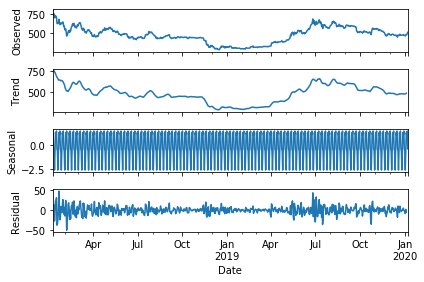

In [23]:
seasonal_decompose(transformed_df).plot()
plt.show()

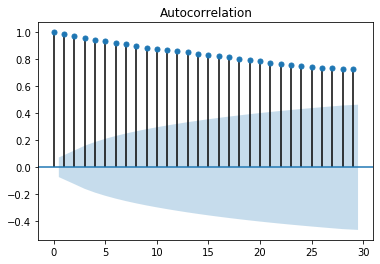

In [25]:
plot_acf(transformed_df)
plt.show()

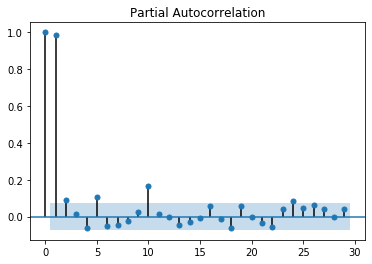

In [26]:
plot_pacf(transformed_df)
plt.show()

In [27]:
model = SARIMAX(transformed_df, order = ((0,0,0,0,0,0,0,0,1,0,0,0,0,1),1,(1,0,1,1,1)))


C:\Users\willi\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [28]:
model_fit = model.fit(disp = True)

In [29]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   Statespace Model Results                                  
=============================================================================================
Dep. Variable:                                 close   No. Observations:                  731
Model:             SARIMAX((9, 14), 1, (1, 3, 4, 5))   Log Likelihood               -2923.101
Date:                               Tue, 07 Jan 2020   AIC                           5860.202
Time:                                       14:48:10   BIC                           5892.354
Sample:                                   01-07-2018   HQIC                          5872.607
                                        - 01-07-2020                                         
Covariance Type:                                 opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L9         -0.0995      0.031     -3.167      0.002      -0.161      -0.038
ar.L14         0.0618      0.027      2.315      0.021       0.009       0.114
ma.L1         -0.0533      0.026     -2.011      0.044      -0.105      -0.001
ma.L3          0.0631      0.027      2.325      0.020       0.010       0.116
ma.L4         -0.0698      0.028     -2.528      0.011      -0.124      -0.016
ma.L5          0.0655      0.026      2.521      0.012       0.015       0.116
sigma2       175.9824      5.661     31.086      0.000     164.887     187.078
===================================================================================
Ljung-Box (Q):                       29.80   Jarque-Bera (JB):               561.40
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               0.81   Skew:                            -0.52
Prob(H) (two-sided):                  0.11   Kurtosis:                         7.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

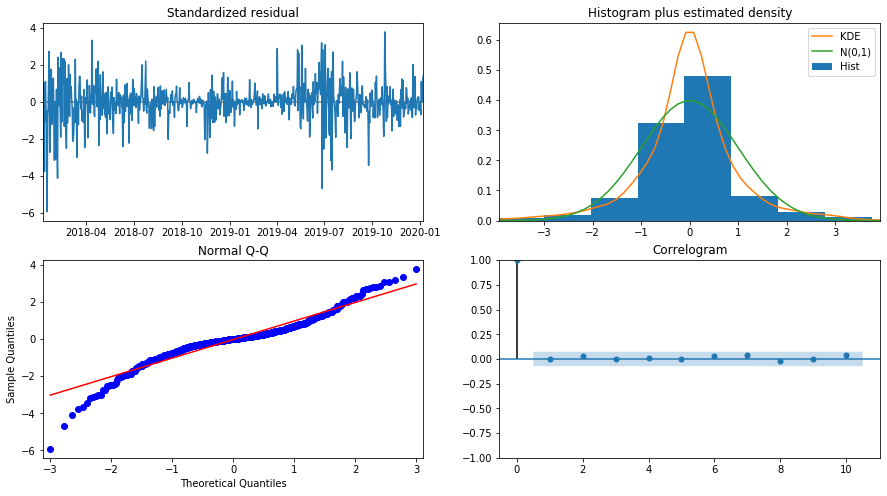

In [30]:
model_fit.plot_diagnostics(figsize=(15,8))
plt.show()

In [31]:
conf_int = model_fit.get_forecast(5)

In [32]:
confidence_intervals = conf_int.conf_int()

In [33]:
confidence_intervals = inv_boxcox(confidence_intervals, lmda)

In [34]:
confidence_intervals

,lower close,upper close
2020-01-08,7532.792058,8810.664207
2020-01-09,7332.966729,9095.151816
2020-01-10,7156.592105,9295.222303
2020-01-11,7005.628579,9506.437334
2020-01-12,6873.270840,9648.208054


In [35]:
predictions = model_fit.predict(start= 731, end = 735 )

In [36]:
predictions

2020-01-08    513.764766
2020-01-09    515.162603
2020-01-10    515.320515
2020-01-11    516.176767
2020-01-12    516.048996
Freq: D, dtype: float64

In [37]:
predicted_close = inv_boxcox(predictions, lmda)

In [38]:
predicted_close

2020-01-08    8162.836306
2020-01-09    8197.215943
2020-01-10    8201.103010
2020-01-11    8222.191339
2020-01-12    8219.043294
Freq: D, dtype: float64

In [39]:
final_df = confidence_intervals.copy()

In [40]:
final_df['predicted_close'] = predicted_close

In [41]:
final_df = final_df.round(2)

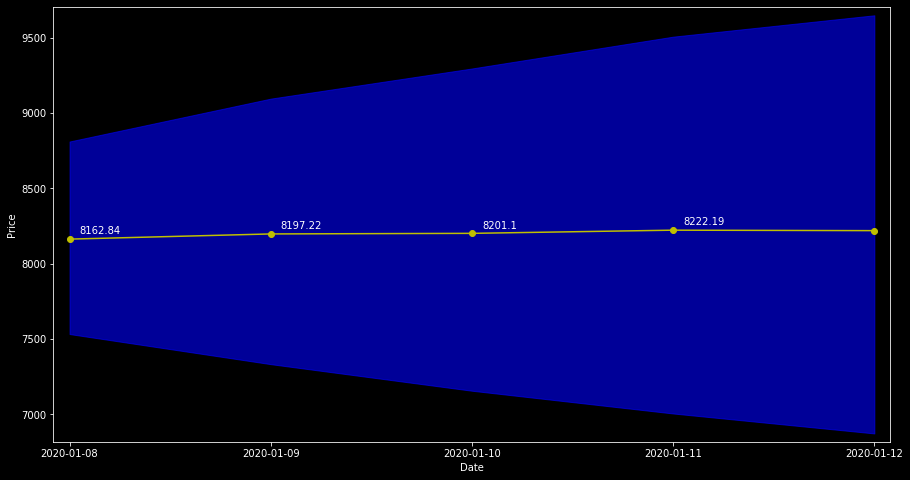

In [75]:
plt.style.use('dark_background')
plt.figure(figsize = (15,8))
plt.plot(final_df['predicted_close'], marker = 'o', color = 'y')
plt.fill_between(final_df.index, final_df['lower close'], final_df['upper close'], color = 'b', alpha = 0.6)
plt.ylabel('Price')
plt.xlabel('Date')
plt.margins(0.02)
plt.xticks(final_df.index)
for i,j in zip(final_df.index[0:4], final_df['predicted_close'][0:4]):
    plt.annotate(str(j),xy=(i,j), xytext = (10,5), textcoords= 'offset points')
plt.show()